# Automatic TICI

## Import Modules

In [0]:
# Basics
import numpy as np

# Dataset file I/O
from google.colab import drive
import os
from scipy.io import loadmat, savemat

# Image processing
import matplotlib.pyplot as plt
import skimage.filters as filters
from skimage.transform import rescale

# Machine learning
from tensorflow import keras
from sklearn.model_selection import KFold

## Helper Functions

### Dataset File I/O

Specify paths to directories.

In [18]:
BASE_DIR = os.getcwd()

# Mount the google drive to the virtue machine running this script.
# This will prompt for authorization.
DRIVE_MOUNT_DIR = os.path.join(os.getcwd(), 'drive')
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

REPOSITORY_NAME = 'CS168-Automatic-TICI'
REPOSITORY = os.path.join(DRIVE_MOUNT_DIR, 'My Drive', REPOSITORY_NAME)

DATA_DIR = os.path.join(REPOSITORY, 'data')
FEATURE_IMAGES_DIR = os.path.join(REPOSITORY, 'feature_images')

Mounted at /content/drive


Get the file list for a given directory.

In [0]:
# Get a list of full paths of all mat files in a specified directory.
def get_file_list(dir):
    for root, _dirs, files in os.walk(dir):
        files = list(filter(lambda fname: fname.lower().endswith('.mat'),
                            sorted(files)))
    nfiles = len(files)
    print('{} mat files found in the directory \'{}\'.'.format(nfiles, dir))
    return nfiles, files

Reset a directory.

In [0]:
def reset_dir(dir):
    !if test -d '$dir'; then rm -r '$dir'; fi
    !mkdir "$dir"

### Algorithm to Select Feature Image

In [0]:
# Returns:
#     success -- boolean
#     image   -- 2D array of the chosen image, or None
def choose_image(image_set):
    # Convert a set of gray scale images to a set of "binary image"s, in
    # which each pixel is either white (1 or True) or black (0 or False).
    def gray2binary(image_set):
        thresholds = list(map(filters.threshold_li, image_set))

        # When an image's frequency is too low, filters.threshold_li may 
        # cause a divide-by-zero RuntimeWarning, and the corresponding
        # threshold will be 0. So we need to remove zeros in thresholds.
        new_image_set = []
        for i in range(len(image_set)):
            if thresholds[i] > 0:
                new_image_set.append(image_set[i])

        thresholds = list(filter(lambda th: th > 0, thresholds))

        result = []
        for i in range(len(thresholds)):
            result.append(new_image_set[i] > thresholds[i])
        return new_image_set, result
    
    # Summarize where the middle artery reaches.
    def summarize_middle_artery(image_set):
        # Assume all the images in an image set have the same dimensions.
        image_count, image_height, image_width = np.shape(image_set)
        result = []
        for image in image_set:
            # Only consider the middle 1/4 of the upper 1/4 image.
            middle_section = image[0:int(image_height/4), int(image_width*3/8):int(image_width*5/8)]

            summary = list(map(all, middle_section))

            result.append(summary)
        return np.array(result)

    
    new_image_set, binary_image_set = gray2binary(image_set)
    middle_artery_summary_image_set = summarize_middle_artery(binary_image_set)
    image_count, image_height = np.shape(middle_artery_summary_image_set)
    
    flagOn = False    
    for i in range(image_count):
        nonzeroCount = np.count_nonzero(middle_artery_summary_image_set[i])
        if flagOn and nonzeroCount > 0 and nonzeroCount < image_height / 2:
            return True, new_image_set[i]
        elif nonzeroCount > image_height / 2:
            flagOn = True
    return False, None

### Extract and Store Feature Image for an Image Set 

Each mat file contains an image set that represents the revascularization of a patient, and a TICI score. Read the files and output the image sets and TICI scores. Explore one of the image sets to get the image set dimensions.

In [0]:
# Given the input directory and a file name, output the key frame and the
# TICI score to the output directory.
# Returns:
#     success -- boolean
#     message -- string, the reason if success==False
def extract_feature_image(input_dir, fname, output_dir, verbose=False):
    content = loadmat(os.path.join(input_dir, fname))
    
    # If verbose is True, print the dictionary keys of the mat file content.
    if verbose:
        print('keys = {}'.format(sorted(content.keys())))

    raw_image_set, TICI = content['X'], content['TICI_report']
    
    # The TICI scores in the mat files are in the form of nested np.ndarray's
    # of either strings, numbers, of nan. e.g., ['2a'], [[3]], [[nan]].
    # With assumption of this structure, unify TICI format into a string.
    while isinstance(TICI, np.ndarray):
        TICI = TICI[0] if len(TICI) > 0 else ''
    TICI = str(TICI)
    
    # Ignore the image sets whose TICI score is missing.
    if TICI == 'nan':
        return False, 'The TICI score is "nan".'

    # Originally, raw_image_set[:, :, k] is the kth image.
    # Reorder the dimensions such that raw_image_set[k, :, :] is the kth image.
    image_set = np.transpose(raw_image_set, (2, 0, 1))

    # Only one image from each image set is selected to be fed into the model.
    imgNotNone, image = choose_image(image_set)
    
    if imgNotNone:
        savemat(os.path.join(output_dir, fname), {
            'image': image,
            'TICI': TICI
        })
        return True, ''
    else:
        return False, 'Feature image not found.'

    return False, ''

### Reformat TICI scores

In [0]:
# The number of different TICI scores.
# Including 0, 1, 2a, 2b, 3.
NUM_TICI_CLASSES = 5

# Convert a TICI string to a number
def map_TICI_str_to_num(TICI):
    relation = {
        '0': 0,
        '1': 1,
        '2a': 2,
        '2b': 3,
        '3': 4,
        '0 (bilateral MCA)': 0,
        '2a?': 2
    }
    return relation[TICI]

# Convert a numerical encoded TICI to a string
def map_TICI_num_to_str(label):
    relation = ['0', '1', '2a', '2b', '3']
    return relation[label]

### Image Augmentation

Build the data augmentation generator

In [0]:
# Return the ImageDataGenerator instance required for image augmentation.
def get_datagen():
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )
    return datagen

Generate augmented dataset

In [0]:
def generate_augmented_dataset(datagen, original_images, TICIs, factor):
    l = len(original_images)
    print('Generating {} times augmented dataset for {} image(s)...'
          .format(factor, l))
    if l == 0:
        return np.array([]), np.array([])
    original_images = np.array(original_images)
    original_images = original_images.reshape(original_images.shape + (1,))

    count = 0
    augmented_images = []
    augmented_TICIs = []
    for batch_X, batch_y in datagen.flow(original_images,
                                         TICIs,
                                         batch_size=l):
        augmented_images.extend(batch_X)
        augmented_TICIs.extend(batch_y)      
        count += 1
        if count >= factor:
            print('{}00% image dataset generated for {} image(s).'
                  .format(factor, l))
            break  # otherwise the generator would loop indefinitely
    return np.array(augmented_images), np.array(augmented_TICIs)

### Create and Initialize Model

In [0]:
def create_model(input_shape, n_classes):
    # Build the model with tensorflow.keras.
    # The general idea is to reduce the size by maxpooling and 
    # extract more features with convolutions of an increasing 
    # number of filters.
    l = keras.layers
    
    model = keras.Sequential([
        l.Conv2D(16, 5, padding='same', activation='relu',
                 input_shape=input_shape,
                 kernel_regularizer=keras.regularizers.l2(0.01)),
        l.MaxPooling2D(pool_size=(8, 8), strides=(8, 8), padding='same'),
        l.BatchNormalization(),

        l.Conv2D(16, 5, padding='same', activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.01)),
        l.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
        l.BatchNormalization(),

        l.Flatten(),
        l.Dropout(0.5),
        l.Dense(n_classes, activation='softmax',
                kernel_regularizer=keras.regularizers.l2(0.01))
    ])

    model.summary()
    
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    
    return model

### Prepare Model Input

In [0]:
def prepare_model_input(input_dir):
    nfiles, files = get_file_list(input_dir)
    if nfiles == 0:
        print('No input files found in the directory {}. ' +
              'Please run select_feature_images first.'
              .format(input_dir))
    
    images = []
    TICIs = []

    # Extract the image set and TICI information for all input mat files.
    for n in range(nfiles):
        # Print the progress.
        if n % 10 == 0 or n == nfiles - 1:
            print('{} / {} done'.format(n, nfiles))
        content = loadmat(os.path.join(FEATURE_IMAGES_DIR, files[n]))
        image, TICI = content['image'], content['TICI']
        images.append(rescale(image, 1.0 / 4.0, anti_aliasing=True))
        TICIs.append(str(TICI[0]))
    
    # Convert TICI scores in the form of strings to numeric labels 
    # before fed to the model.
    TICI_nums = list(map(map_TICI_str_to_num, TICIs))
    # Convert the array of integer labels (0 ~ NUM_TICI_CLASSES-1) to an
    # array of one-hot (aka one-of-K) encoded labels, for better accuracy.
    TICI_one_hot = keras.utils.to_categorical(TICI_nums, NUM_TICI_CLASSES)
    
    return np.array(images), np.array(TICI_one_hot)

## Main

### Select Feature Images

In [0]:
def select_feature_images(input_dir, output_dir):
    ignored_files_count = 0
    reset_dir(output_dir)

    nfiles, files = get_file_list(input_dir)
    for n in range(nfiles):
        # Print the progress.
        if n % 10 == 0 or n == nfiles - 1:
            print('{} / {} done'.format(n, nfiles))
        fname = files[n]
        success, message = extract_feature_image(input_dir, fname, output_dir)
        if not success:
            ignored_files_count += 1
            print('Data file {} ignored. Reason: {}'.format(fname, message))

    print('\n\nFinish extracting feature images from {} out of {} files. {} are ignored.'
          .format(nfiles - ignored_files_count, nfiles, ignored_files_count))

In [20]:
select_feature_images(DATA_DIR, FEATURE_IMAGES_DIR)

201 mat files found in the directory '/content/drive/My Drive/CS168-Automatic-TICI/data'.
0 / 201 done


/usr/local/lib/python3.6/dist-packages/skimage/filters/thresholding.py:596: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


Data file fractals_101.mat ignored. Reason: Feature image not found.
Data file fractals_102.mat ignored. Reason: Feature image not found.
Data file fractals_103.mat ignored. Reason: The TICI score is "nan".
10 / 201 done
Data file fractals_108.mat ignored. Reason: Feature image not found.
Data file fractals_115.mat ignored. Reason: The TICI score is "nan".
20 / 201 done
Data file fractals_117.mat ignored. Reason: The TICI score is "nan".
Data file fractals_124.mat ignored. Reason: The TICI score is "nan".
30 / 201 done
Data file fractals_127.mat ignored. Reason: Feature image not found.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Data file fractals_132.mat ignored. Reason: The TICI score is "nan".
Data file fractals_134.mat ignored. Reason: The TICI score is "nan".
40 / 201 done
Data file fractals_137.mat ignored. Reason: Feature image not found.
Data file fractals_139.mat ignored. Reason: Feature image not found.
Data file fractals_14.mat ignored. Reason: Feature image not found.
Data file fractals_140.mat ignored. Reason: Feature image not found.
50 / 201 done
Data file fractals_144.mat ignored. Reason: Feature image not found.
Data file fractals_150.mat ignored. Reason: Feature image not found.
60 / 201 done
Data file fractals_153.mat ignored. Reason: Feature image not found.
Data file fractals_156.mat ignored. Reason: Feature image not found.
Data file fractals_16.mat ignored. Reason: Feature image not found.
Data file fractals_160.mat ignored. Reason: Feature image not found.
70 / 201 done
80 / 201 done
Data file fractals_172.mat ignored. Reason: Feature image not found.
Data file fractals_173.mat ignored.

### Train the Model (Including Image Augmentation)

Assess model performance

In [0]:
def assess_model_performance(input_dir, K):
    # Read and reformat input data    
    images, TICI_one_hot = prepare_model_input(input_dir)

    # Setup image augmentation
    datagen = get_datagen()
    AUGMENTATION_FACTOR = 40
    
    # Explore image augmentation on a sample image
    sample_count = 0
    sample_images, sample_TICIs  = [images[0]], [TICI_one_hot[0]]

    plt.figure()
    plt.imshow(images[0], cmap='gray')

    plt.figure(figsize=(10, 10))
    sample_aug_img, sample_aug_TICIs = generate_augmented_dataset(
        datagen, sample_images, sample_TICIs, 9)
    print(sample_TICIs, sample_aug_TICIs)
    for i in range(len(sample_aug_img)):
        plt.subplot(330 + 1 + i)
        h, w, _ = np.shape(sample_aug_img[i])
        plt.imshow(sample_aug_img[i].reshape(h,w), cmap='gray')
    
    # K-fold cross validation
    BATCH_SIZE = 32
    EPOCHS = 30
    kf = KFold(n_splits=K)

    model_performance_results = []
    for train_index, val_index in kf.split(images):
        x_train, x_val = images[train_index], images[val_index]
        y_train, y_val = TICI_one_hot[train_index], TICI_one_hot[val_index]
        x_val = x_val.reshape(x_val.shape + (1,))

        augmented_x_train, augmented_y_train = generate_augmented_dataset(
            datagen, x_train, y_train, AUGMENTATION_FACTOR)

        model = create_model(np.shape(images[0]) + (1,), NUM_TICI_CLASSES)
        model.fit(
            x=augmented_x_train,
            y=augmented_y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_data=(x_val, y_val)
        )

        train_loss, train_acc = model.evaluate(augmented_x_train, 
                                               augmented_y_train)
        validation_loss, validation_acc = model.evaluate(x_val, y_val)
        model_performance_results.append([train_loss, train_acc, 
                                          validation_loss, validation_acc])
        print('\n\n\n')
    return model_performance_results

145 mat files found in the directory '/content/drive/My Drive/CS168-Automatic-TICI/feature_images'.
0 / 145 done


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


10 / 145 done
20 / 145 done
30 / 145 done
40 / 145 done
50 / 145 done
60 / 145 done
70 / 145 done
80 / 145 done
90 / 145 done
100 / 145 done
110 / 145 done
120 / 145 done
130 / 145 done
140 / 145 done
144 / 145 done
Generating 9 times augmented dataset for 1 image(s)...
900% image dataset generated for 1 image(s).
[array([0., 0., 1., 0., 0.], dtype=float32)] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Generating 40 times augmented dataset for 116 image(s)...
4000% image dataset generated for 116 image(s).
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 256, 256, 16)      416       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
________________________________________

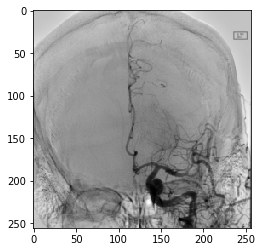

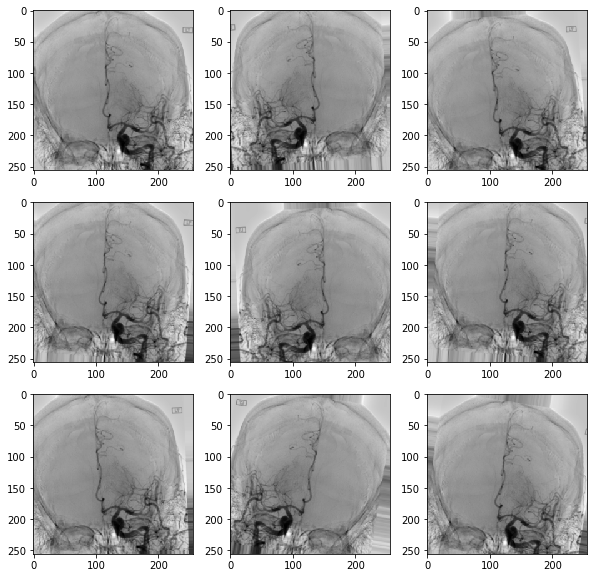

In [34]:
K = 5
performance = assess_model_performance(FEATURE_IMAGES_DIR, K)

In [35]:
print('Model performance on the {}-fold cross validation:'.format(K))
print('\ttrain_loss\t\ttrain_acc\t\tvalidation_loss\t\tvalidation_acc')
for i in range(K):
    print('{}\t{}\t{}\t{}\t{}'.format(
        i + 1,
        performance[i][0],
        performance[i][1],
        performance[i][2],
        performance[i][3]))

Model performance on the 5-fold cross validation:
	train_loss		train_acc		validation_loss		validation_acc
1	3.636836732667068	0.442241370677948	7.417378902435303	0.24137930572032928
2	1.5005918239725047	0.5543103218078613	1.83278489112854	0.48275861144065857
3	0.6084150359548371	0.8450431227684021	4.078393936157227	0.3448275923728943
4	10.236703701676994	0.32758620381355286	10.771405220031738	0.27586206793785095
5	0.5464012191213411	0.8868534564971924	2.233330249786377	0.4482758641242981


Train the Model on All Data

In [0]:
def train_model(input_dir, output_dir):
    # Read and reformat input data    
    images, TICI_one_hot = prepare_model_input(input_dir)

    # Training settings
    BATCH_SIZE = 32
    EPOCHS = 30

    # Image augmentation
    datagen = get_datagen()
    AUGMENTATION_FACTOR = 40
    
    augmented_x_train, augmented_y_train = generate_augmented_dataset(
        datagen, images, TICI_one_hot, AUGMENTATION_FACTOR)

    model = create_model(np.shape(images[0]) + (1,), NUM_TICI_CLASSES)
    model.fit(
        x=augmented_x_train,
        y=augmented_y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1
    )
    
    # Save the model
    model.save(os.path.join(output_dir, 'model.h5'))

In [37]:
train_model(FEATURE_IMAGES_DIR, REPOSITORY)

145 mat files found in the directory '/content/drive/My Drive/CS168-Automatic-TICI/feature_images'.
0 / 145 done


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


10 / 145 done
20 / 145 done
30 / 145 done
40 / 145 done
50 / 145 done
60 / 145 done
70 / 145 done
80 / 145 done
90 / 145 done
100 / 145 done
110 / 145 done
120 / 145 done
130 / 145 done
140 / 145 done
144 / 145 done
Generating 40 times augmented dataset for 145 image(s)...
4000% image dataset generated for 145 image(s).
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 256, 256, 16)      416       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_v1_32 (B (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 16)        6416      
_________________________________________________________________
max_pooling2d_33 (